In [2]:
import numpy as np
import tensorflow as tf
import random
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import mnist
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import os
import sys

2025-03-15 16:19:18.230165: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-15 16:19:18.598321: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-15 16:19:18.892331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742051959.223876   48310 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742051959.295481   48310 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 16:19:19.898152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
# Work-around for loading a module from a parent folder in Jupyter/Notebooks
parent_dir = os.path.abspath(os.path.join('..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from modules.autoencoders import create_convolutional_autoencoder, create_autoencoder

In [4]:
# Caricamento dei dati
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
# Caricamento dei dati
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, batch_size=-1, as_supervised=True)
x_train, y_train = tfds.as_numpy(train_ds)
x_test, y_test = tfds.as_numpy(test_ds)
#x_train = x_train[:,:,:,0]
#x_test = x_test[:,:,:,0]

/home/hikari/sources/llms-evaluation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 4/4 [00:01<00:00,  2.28 url/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]2025-03-15 16:19:29.854315: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-03-15 16:19:51.437510: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Dataset mnist downloaded and prepared to /home/hikari/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
# Normalizzazione dei pixel a [0, 1]
norm_x_train = x_train.astype('float32') / 255.
norm_x_test = x_test.astype('float32') / 255.

# Dataset Analisys

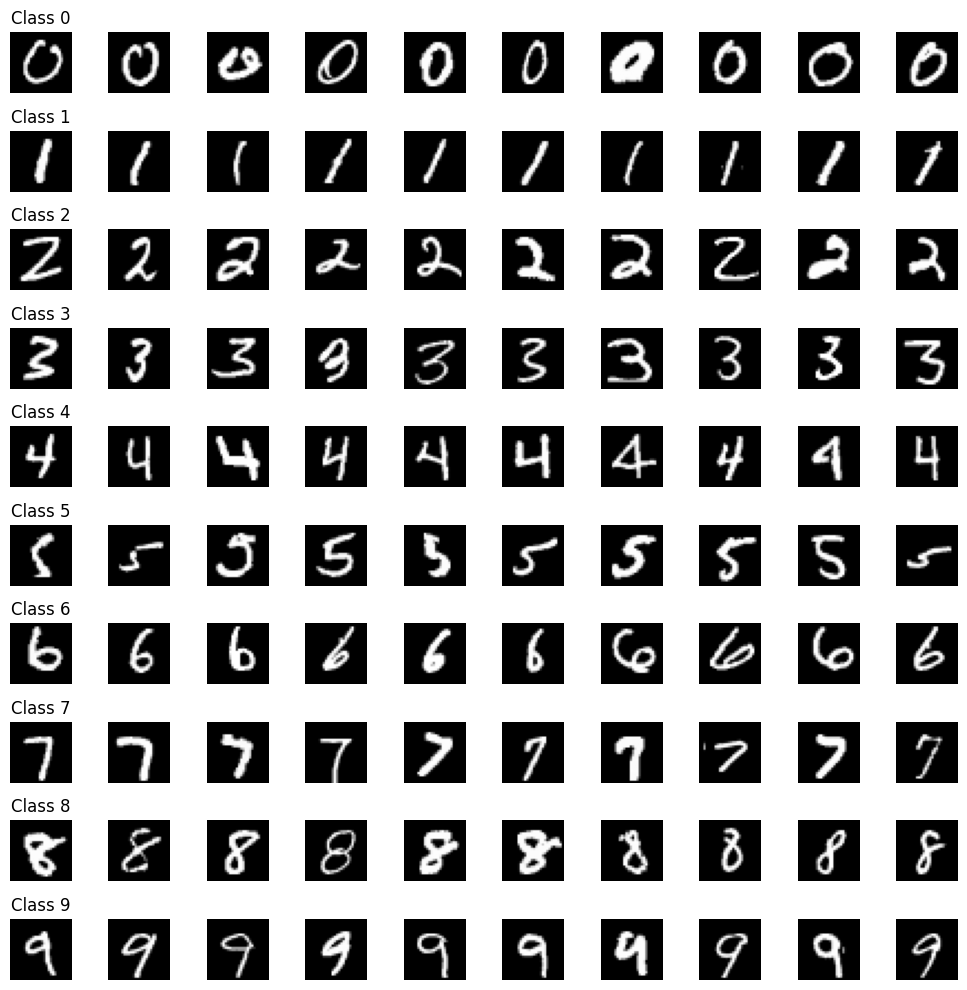

In [7]:
# Troviamo le classi presenti (da 0 a 9)
classes = np.unique(y_train)
n_classes = len(classes)
samples_per_class = 10  # Numero di esempi per classe da visualizzare

# Creiamo una griglia di subplot: righe = n_classes, colonne = samples_per_class
fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(samples_per_class * 1, n_classes * 1))

for i, cls in enumerate(classes):
    # Trova gli indici degli esempi per la classe corrente
    idxs = np.where(y_train == cls)[0]    
    # Mostra l'etichetta sulla prima colonna di ogni riga
    axes[i, 0].set_title(f"Class {cls}")
    j=0    
    # Seleziona randomicamente samples_per_class indici tra quelli della classe corrente
    for idx in random.sample(list(idxs), samples_per_class):
        # Seleziona l'immagine
        img = x_train[idx]
        # Visualizza l'immagine
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        j=j+1

plt.tight_layout()
plt.show()

# Utils

In [8]:
# Funzione per il sampling: genera n vettori latenti campionando da una distribuzione
# normale parametrizzata dalle statistiche dei vettori latenti del training set.
def get_2d_sample_from_norm_distr(mean, std, inf_lim, sup_lim):
    """
    Genera n vettori latenti campionando da una distribuzione normale con mean e std
    calcolati dai dati di training.
    """
    return np.random.normal(loc=mean, scale=std, size=(inf_lim, sup_lim))

In [9]:
def plot_img(immagine, titolo="Sampled Image", figsize=(4,4)):
    """
    Plotta una immagine, convertendola se necessario da vettoriale (784,) a matrice (28,28).

    Parametri:
    - immagine: numpy array rappresentante l'immagine (forma (784,) o (28,28))
    - titolo: titolo da visualizzare sul plot
    """
    # Se l'immagine è un vettore piatto, la rimodelliamo in 28x28
    if immagine.ndim == 1 or (immagine.ndim == 2 and immagine.shape[0] * immagine.shape[1] == 784):
        immagine = immagine.reshape(28, 28)

    plt.figure(figsize=figsize)
    plt.imshow(immagine, cmap='gray')
    plt.title(titolo)
    plt.axis('off')
    plt.show()

In [10]:
def plot_encoding_tsne(encoder, data, labels, sample_size=None, perplexity=30, random_state=42, title="t-SNE projection of the latent space"):
    """
    Calcola l'encoding dei dati con il modello encoder e proietta le rappresentazioni latenti in 2D
    utilizzando t-SNE. I punti sono colorati in modo discreto in base alle etichette (classi).

    Parametri:
    - encoder: modello Keras per ottenere l'encoding.
    - dati: array dei dati in input (es. immagini).
    - labels: array delle etichette corrispondenti.
    - sample_size: (opzionale) numero di campioni da utilizzare per t-SNE (se None usa tutti i dati).
    - perplexity: parametro perplexity per t-SNE.
    - random_state: seme per la riproducibilità.
    """
    # Se sample_size è definito e minore del numero totale di dati, campiona casualmente
    if sample_size is not None and sample_size < len(data):
        idx = np.random.choice(len(data), size=sample_size, replace=False)
        data = data[idx]
        labels = labels[idx]

    # Calcola l'encoding dei dati
    latent = encoder.predict(data)

    # Riduci a 2 dimensioni con t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    latent_2d = tsne.fit_transform(latent)

    # Ottieni le etichette uniche
    unique_labels = np.unique(labels)
    # Se ci sono al massimo 10 classi, usiamo 'tab10', altrimenti 'tab20'
    if len(unique_labels) <= 10:
        cmap = plt.get_cmap('tab10', len(unique_labels))
    else:
        cmap = plt.get_cmap('tab20', len(unique_labels))

    plt.figure(figsize=(8, 6))
    # Plot separato per ogni classe con colori distinti
    for i, ul in enumerate(unique_labels):
        idx = labels == ul
        plt.scatter(latent_2d[idx, 0], latent_2d[idx, 1],
                    color=cmap(i), label=str(ul), s=5)

    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(title='Classe')
    plt.show()


# Fast Forward Autoencoder

In [11]:
flatten_x_train = norm_x_train.reshape((len(norm_x_train), -1))
flatten_x_test = norm_x_test.reshape((len(norm_x_test), -1))

input_dim = flatten_x_train.shape[1]
filters=(32, 64, 128)
activations=('relu', 'relu', 'relu')
latent_space_dim=2

autoencoder, encoder, decoder = create_autoencoder(input_dim=input_dim, filters=filters, activations=activations, latent_space_dim=latent_space_dim)

autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │        35,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │        36,592 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,402 (282.82 KB)

 Trainable params: 72,402 (282.82 KB)

 Non-trainable params: 0 (0.00 B)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_1 (Dense)         │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_2 (Dense)         │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_3 (Dense)         │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,810 (139.88 KB)

 Trainable params: 35,810 (139.88 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_1 (Dense)         │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_2 (Dense)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_3 (Dense)         │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_layer (Dense)           │ (None, 784)            │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,592 (142.94 KB)

 Trainable params: 36,592 (142.94 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
autoencoder.compile(optimizer='adam', loss='mse')

In [14]:
history = autoencoder.fit(flatten_x_train, flatten_x_train,
                epochs=10,
                batch_size=512,
                shuffle=True,
                validation_data=(flatten_x_test, flatten_x_test))

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1510 - val_loss: 0.0683
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0661 - val_loss: 0.0594
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0580 - val_loss: 0.0556
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0552 - val_loss: 0.0534
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0531 - val_loss: 0.0518
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0515 - val_loss: 0.0508
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0507 - val_loss: 0.0501
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0499 - val_loss: 0.0490
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0486 - val_loss: 0.0480
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0478 - val_loss: 0.0472


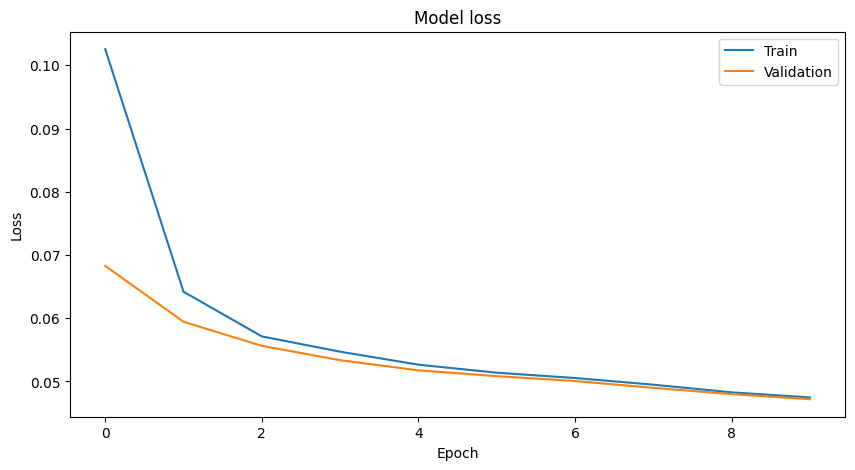

In [15]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [16]:
# -------------------------------
# Calcolo delle statistiche dello spazio latente
# (utilizzato per il sampling)
# -------------------------------
latent_reps = encoder.predict(flatten_x_train)
latent_mean = np.mean(latent_reps, axis=0)
latent_std = np.std(latent_reps, axis=0)

#for i in range(0,len(latent_mean)):
#    print(f"{i} | Model >>> Mean: {latent_mean[i]}, Std: {latent_std[i]}")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


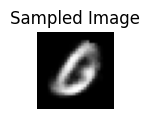

In [29]:
encoded_img = get_2d_sample_from_norm_distr(latent_mean, latent_std, 1, latent_space_dim)
# Decodifica per ottenere la ricostruzione
decoded_img = decoder.predict(encoded_img)
# Genera una nuova immagine
plot_img(decoded_img, figsize=(1,1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


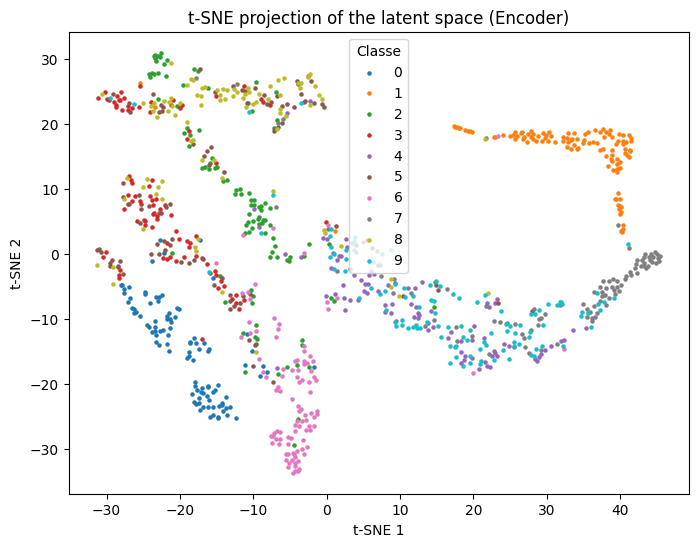

In [30]:
plot_encoding_tsne(encoder, flatten_x_test, y_test, sample_size=1000, title=f"t-SNE projection of the latent space (Encoder)")

# Convoluted Autoencoder

In [47]:
conv_input_shape = (norm_x_train.shape[1:][0], norm_x_train.shape[1:][1], 1)
conv_filters=(32, 64, 64, 64)
conv_activations=('relu', 'relu', 'relu', 'relu')
conv_kernels=(3, 3, 3, 3)
conv_strides=(1, 2, 2, 1)
conv_latent_space_dim=2

conv_autoencoder, conv_encoder, conv_decoder = create_convolutional_autoencoder(
    input_shape=conv_input_shape, 
    conv_filters=conv_filters, 
    conv_kernels=conv_kernels, 
    conv_strides=conv_strides, 
    conv_activations=conv_activations,
    latent_space_dim=conv_latent_space_dim
)

conv_autoencoder.summary()
conv_encoder.summary()
conv_decoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 2)                   │          99,842 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         121,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,379 (864.76 KB)

 Trainable params: 220,547 (861.51 KB)

 Non-trainable params: 832 (3.25 KB)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_1 (Conv2D)        │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_1 (Activation)          │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_1 (BatchNormalization)    │ (None, 28, 28, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_2 (Conv2D)        │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_2 (Activation)          │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_2 (BatchNormalization)    │ (None, 14, 14, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_3 (Conv2D)        │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_3 (Activation)          │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_3 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_4 (Conv2D)        │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_4 (Activation)          │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_4 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           6,274 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,842 (390.01 KB)

 Trainable params: 99,394 (388.26 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense (Dense)                │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_1       │ (None, 7, 7, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_1 (Activation)          │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_1 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_2       │ (None, 14, 14, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_2 (Activation)          │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_2 (BatchNormalization)    │ (None, 14, 14, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_3       │ (None, 28, 28, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_3 (Activation)          │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_3 (BatchNormalization)    │ (None, 28, 28, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_4       │ (None, 28, 28, 1)           │             577 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sigmoid_layer (Activation)           │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,537 (474.75 KB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 384 (1.50 KB)

In [48]:
conv_autoencoder.compile(optimizer='adam', loss='mse')

In [49]:
tf.config.run_functions_eagerly(True)
conv_history = conv_autoencoder.fit(norm_x_train, norm_x_train,
                epochs=10,
                batch_size=512,
                shuffle=True,
                validation_data=(norm_x_test, norm_x_test))

Epoch 1/10


c:\Workspace\Python\llms-evaluation\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


118/118 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - loss: 0.1242 - val_loss: 0.1001
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - loss: 0.0569 - val_loss: 0.1015
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - loss: 0.0504 - val_loss: 0.0793
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 0.0473 - val_loss: 0.0554
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 0.0454 - val_loss: 0.0472
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 0.0440 - val_loss: 0.0494
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 0.0455 - val_loss: 0.0432
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 0.0425 - val_loss: 0.0424
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - loss: 0.0419 - val_loss: 0.0422
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - loss: 0.0417 - val_loss: 0.0420


In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(conv_history.history['loss'])
plt.plot(conv_history.history['val_loss'])
plt.title('Model Conv loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# -------------------------------
# Calcolo delle statistiche dello spazio latente
# (utilizzato per il sampling)
# -------------------------------
conv_latent_reps = conv_encoder.predict(norm_x_train)
conv_latent_mean = np.mean(conv_latent_reps, axis=0)
conv_latent_std = np.std(conv_latent_reps, axis=0)

#for i in range(0,len(conv_latent_mean)):
#    print(f"{i} | Conv Model >>> Mean: {conv_latent_mean[i]}, Std: {conv_latent_std[i]}")

In [ ]:
conv_encoded_img = get_2d_sample_from_norm_distr(conv_latent_mean, conv_latent_std, 1, latent_space_dim)
# Decodifica per ottenere la ricostruzione
conv_decoded_img = conv_decoder.predict(conv_encoded_img)
# Genera una nuova immagine
plot_img(conv_decoded_img[0], figsize=(1,1))

In [ ]:
plot_encoding_tsne(conv_encoder, norm_x_test, y_test, sample_size=1000, title=f"t-SNE projection of the latent space (Encoder Conv)")